In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

In [39]:

def extract_data(file_path):
    with open(file_path, 'r') as f:
        content = f.readlines()

    activity_log_line = None
    for line in content:
        if "Activity log file:" in line:
            activity_log_line = line
            break

    if activity_log_line:
        # Extract the file name from the line
        file_name = re.findall(r"Activity log file:\s*(.*?\.dat)", activity_log_line)[0]

        # Extract machine_number (S414) from the file name
        machine_number = re.findall(r'S(\d+)', file_name)[0]

        # Extract control_number (CTRL4067) from the file name
        control_number = re.findall(r'CTRL(\d+)', file_name)[0]

    # Find the line that contains "Interrupt"
    interrupt_line = None
    for line in content:
        if "Interrupt" in line:
            interrupt_line = line
            break

    s_vsense = None
    s_ovp = None
    for line in content:
        if "S_VSENSE" in line:
            print(line)
            s_vsense = re.findall(r"(-?\d+\.?\d*)", line)[0]
        if "S_OVP" in line:
            s_ovp = re.findall(r"(-?\d+\.?\d*)", line)[0]

    if interrupt_line:
        # Extract timestamp
        timestamp = re.findall(r'\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}', interrupt_line)[0]

        # Find the last test step before the interruption
        test_step = None
        for i in range(content.index(interrupt_line) - 1, -1, -1):
            if "Test Step:" in content[i]:
                test_step = re.findall(r"Test Step:\s*(.*?)\s*", content[i])[0]
                break

        return {
            'machine_number': machine_number,
            'control_number': control_number,
            'timestamp': timestamp,
            'test_step': test_step,
            'S_VSENSE': s_vsense,
            'S_OVP': s_ovp
        }
    else:
        return None

In [40]:

def process_folder(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".dat"):
            file_path = os.path.join(folder_path, filename)
            data = extract_data(file_path)
            if data:
                all_data.append(data)

    return pd.DataFrame(all_data)

In [41]:

def visualize_data(df):
    # Convert timestamp to datetime for easier plotting
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Scatter Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df['timestamp'], df['S_VSENSE'], label='S_VSENSE', marker='o')
    plt.scatter(df['timestamp'], df['S_OVP'], label='S_OVP', marker='x')
    plt.xlabel('Timestamp')
    plt.ylabel('Values')
    plt.title('S_VSENSE and S_OVP Over Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Box Plot (Filtered by Test Step)
    plt.figure(figsize=(10, 6))
    df.boxplot(column=['S_VSENSE', 'S_OVP'], by='test_step', rot=45)
    plt.xlabel('Test Step')
    plt.ylabel('Values')
    plt.title('S_VSENSE and S_OVP Grouped by Test Step')
    plt.tight_layout()
    plt.show()

Breithorn
S_VSENSE            3.731     

S_VSENSE            3.731     

S_VSENSE            1.298     

S_VSENSE            1.298     

S_VSENSE            3.751     

S_VSENSE            3.731     

S_VSENSE            3.731     

S_VSENSE            3.731     

S_VSENSE            3.731     

S_VSENSE            3.731     

S_VSENSE            3.731     

S_VSENSE            3.731     



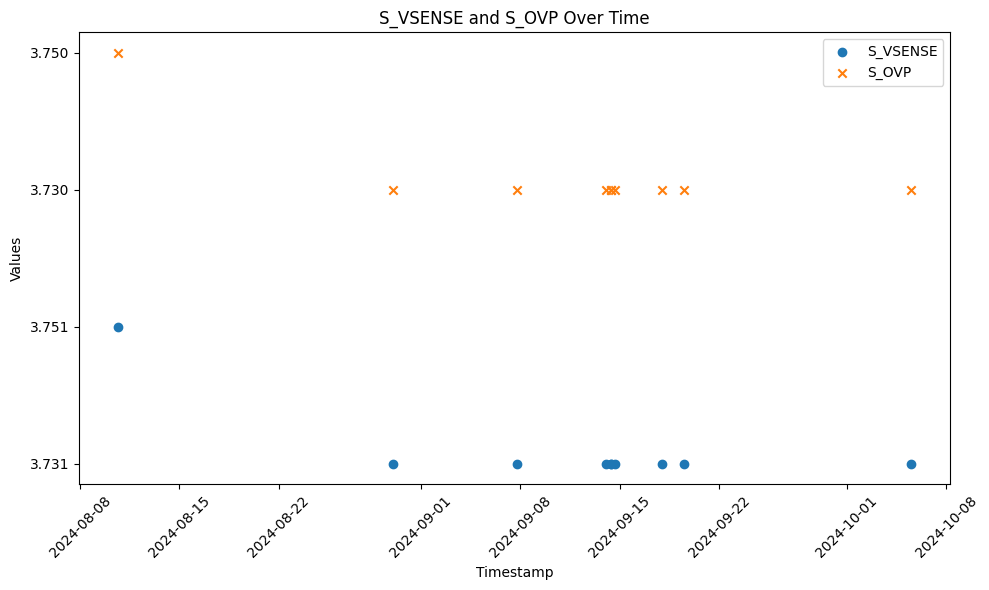

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<Figure size 1000x600 with 0 Axes>

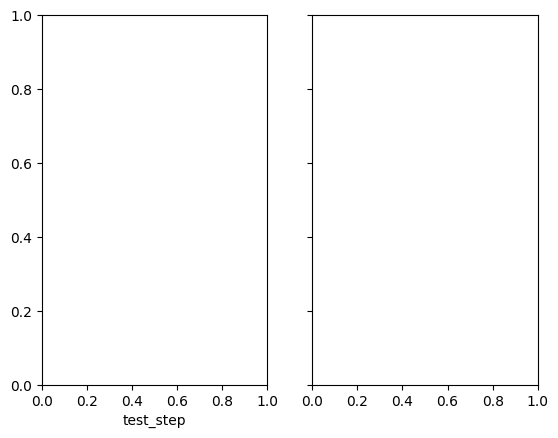

In [42]:
if True:
    folder_path = "data-voltages"  # Replace with the actual path to your folder
    for product_name in os.listdir(folder_path):
        print(product_name)
        product_folder_path = os.path.join(folder_path, product_name)
        df = process_folder(product_folder_path)
        df.to_csv(f"{product_name}-output.csv", index=False)  # Save data to CSV
        visualize_data(df)